# Homework 5.3: AlexNet Implementation and Activation Visualization

## Objectives

1. Implement AlexNet architecture
2. Visualize activation maps for LeNet at each convolutional layer
3. Visualize activation maps for AlexNet at each convolutional layer
4. Analyze and draw conclusions about the patterns/features detected by convolutions

## Tasks Overview

- **Task 1**: Implement AlexNet from scratch
- **Task 2**: Train AlexNet on MNIST dataset
- **Task 3**: Visualize activation maps for LeNet
- **Task 4**: Visualize activation maps for AlexNet
- **Task 5**: Compare and analyze learned features

## Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Task 1: Implement AlexNet Architecture

### Original AlexNet Architecture (ImageNet)

AlexNet was designed for ImageNet (224×224×3 images, 1000 classes). We'll adapt it for MNIST (28×28×1 images, 10 classes).

**Original Architecture:**
1. Conv1: 11×11 kernel, 96 filters, stride=4
2. MaxPool: 3×3, stride=2
3. Conv2: 5×5 kernel, 256 filters
4. MaxPool: 3×3, stride=2
5. Conv3: 3×3 kernel, 384 filters
6. Conv4: 3×3 kernel, 384 filters
7. Conv5: 3×3 kernel, 256 filters
8. MaxPool: 3×3, stride=2
9. FC: 4096 units
10. FC: 4096 units
11. FC: num_classes units

**Adaptations for MNIST:**
- Input: 28×28×1 (instead of 224×224×3)
- Smaller kernel sizes and strides
- Fewer filters
- Smaller fully connected layers

In [2]:
class AlexNet(nn.Module):
    """
    AlexNet architecture adapted for MNIST dataset.
    
    Original AlexNet:
    - Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012)
    - Won ImageNet 2012 competition
    - First successful deep CNN for image classification
    
    Adaptations:
    - Input: 28×28×1 (MNIST) instead of 224×224×3 (ImageNet)
    - Reduced number of filters
    - Smaller kernel sizes for first conv layer
    - Smaller FC layers
    """
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        
        # Convolutional layers
        self.features = nn.Sequential(
            # Layer 1: Conv + ReLU + MaxPool
            # Input: 28×28×1 → Output: 13×13×32
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 2: Conv + ReLU + MaxPool
            # Input: 13×13×32 → Output: 6×6×64
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Layer 3: Conv + ReLU
            # Input: 6×6×64 → Output: 6×6×128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 4: Conv + ReLU
            # Input: 6×6×128 → Output: 6×6×128
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 5: Conv + ReLU + MaxPool
            # Input: 6×6×128 → Output: 3×3×64
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Test the architecture
model = AlexNet(num_classes=10).to(device)
print('AlexNet Architecture:')
print(model)

# Test with dummy input
dummy_input = torch.randn(1, 1, 28, 28).to(device)
output = model(dummy_input)
print(f'\nInput shape: {dummy_input.shape}')
print(f'Output shape: {output.shape}')

AlexNet Architecture:
AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=576, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): 

## LeNet Architecture (for comparison)

We'll also implement LeNet-5 to compare activation maps.

In [3]:
class LeNet5(nn.Module):
    """
    LeNet-5 architecture (LeCun et al., 1998)
    Classic CNN for digit recognition
    """
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        
        self.features = nn.Sequential(
            # Conv1: 28×28×1 → 28×28×6
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # → 14×14×6
            
            # Conv2: 14×14×6 → 14×14×16
            nn.Conv2d(6, 16, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # → 7×7×16
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(16 * 7 * 7, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

lenet = LeNet5(num_classes=10).to(device)
print('LeNet-5 Architecture:')
print(lenet)

LeNet-5 Architecture:
LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=120, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


## Load MNIST Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.73MB/s]

Training samples: 60000
Test samples: 10000


## Task 2: Train AlexNet

In [5]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Evaluate
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)
        
        print(f'Epoch {epoch+1}: Loss = {train_loss:.4f}, Test Acc = {test_acc:.2f}%')
    
    return train_losses, test_accuracies

# Train AlexNet
print('Training AlexNet...')
alexnet = AlexNet(num_classes=10).to(device)
alex_losses, alex_accs = train_model(alexnet, train_loader, test_loader, epochs=5)

# Train LeNet
print('\nTraining LeNet-5...')
lenet = LeNet5(num_classes=10).to(device)
lenet_losses, lenet_accs = train_model(lenet, train_loader, test_loader, epochs=5)

Training AlexNet...


Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Loss = 0.3343, Test Acc = 98.44%


Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Loss = 0.0849, Test Acc = 98.96%


Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Loss = 0.0588, Test Acc = 99.12%


Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Loss = 0.0491, Test Acc = 99.28%


Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Loss = 0.0411, Test Acc = 99.08%

Training LeNet-5...


Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1: Loss = 0.3160, Test Acc = 97.49%


Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2: Loss = 0.0791, Test Acc = 98.37%


Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3: Loss = 0.0546, Test Acc = 98.48%


Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4: Loss = 0.0436, Test Acc = 98.73%


Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5: Loss = 0.0351, Test Acc = 98.85%


## Task 3: Visualize Activation Maps for LeNet

Activation maps show what features each convolutional layer detects in the input image.

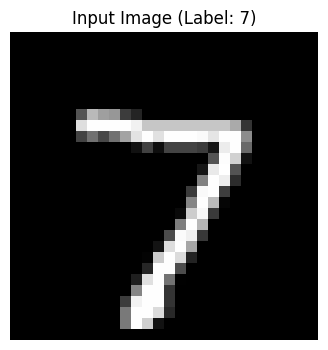

LeNet-5 Activation Maps:


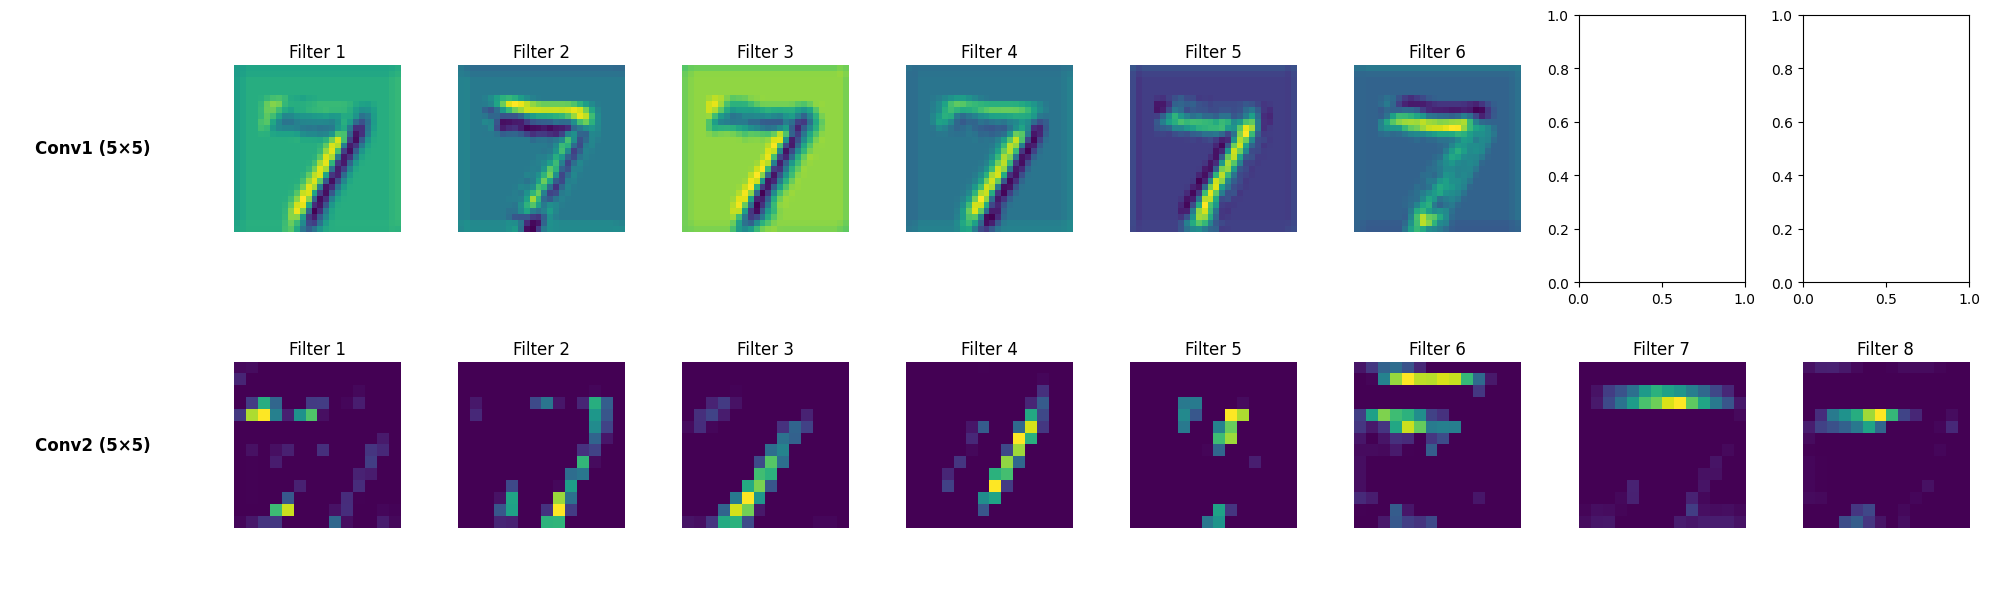

In [6]:
def get_activation_maps(model, image, layer_indices):
    """
    Extract activation maps from specified layers.
    
    Args:
        model: Neural network model
        image: Input image tensor (1, C, H, W)
        layer_indices: List of layer indices to extract activations from
    
    Returns:
        List of activation maps
    """
    activations = []
    
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    
    hooks = []
    for idx in layer_indices:
        hook = model.features[idx].register_forward_hook(hook_fn)
        hooks.append(hook)
    
    model.eval()
    with torch.no_grad():
        _ = model(image)
    
    for hook in hooks:
        hook.remove()
    
    return activations

def visualize_activation_maps(activations, layer_names, num_filters=8):
    """
    Visualize activation maps from multiple layers.
    
    Args:
        activations: List of activation tensors
        layer_names: Names of layers
        num_filters: Number of filters to display per layer
    """
    num_layers = len(activations)
    
    fig, axes = plt.subplots(num_layers, num_filters + 1, figsize=(20, 3 * num_layers))
    
    for layer_idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
        # activation shape: (1, num_filters, H, W)
        activation = activation.squeeze(0)  # (num_filters, H, W)
        
        # Display layer name
        axes[layer_idx, 0].text(0.5, 0.5, layer_name, 
                                ha='center', va='center', fontsize=12, fontweight='bold')
        axes[layer_idx, 0].axis('off')
        
        # Display activation maps
        for filter_idx in range(min(num_filters, activation.shape[0])):
            act_map = activation[filter_idx].numpy()
            axes[layer_idx, filter_idx + 1].imshow(act_map, cmap='viridis')
            axes[layer_idx, filter_idx + 1].set_title(f'Filter {filter_idx + 1}')
            axes[layer_idx, filter_idx + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a test image
test_image, test_label = test_dataset[0]
test_image_batch = test_image.unsqueeze(0).to(device)

# Visualize input image
plt.figure(figsize=(4, 4))
plt.imshow(test_image.squeeze().numpy(), cmap='gray')
plt.title(f'Input Image (Label: {test_label})')
plt.axis('off')
plt.show()

# LeNet: Extract activations from Conv layers (indices 0 and 4)
print('LeNet-5 Activation Maps:')
lenet_activations = get_activation_maps(lenet, test_image_batch, [0, 4])
visualize_activation_maps(lenet_activations, ['Conv1 (5×5)', 'Conv2 (5×5)'], num_filters=8)

## Task 4: Visualize Activation Maps for AlexNet

AlexNet Activation Maps:


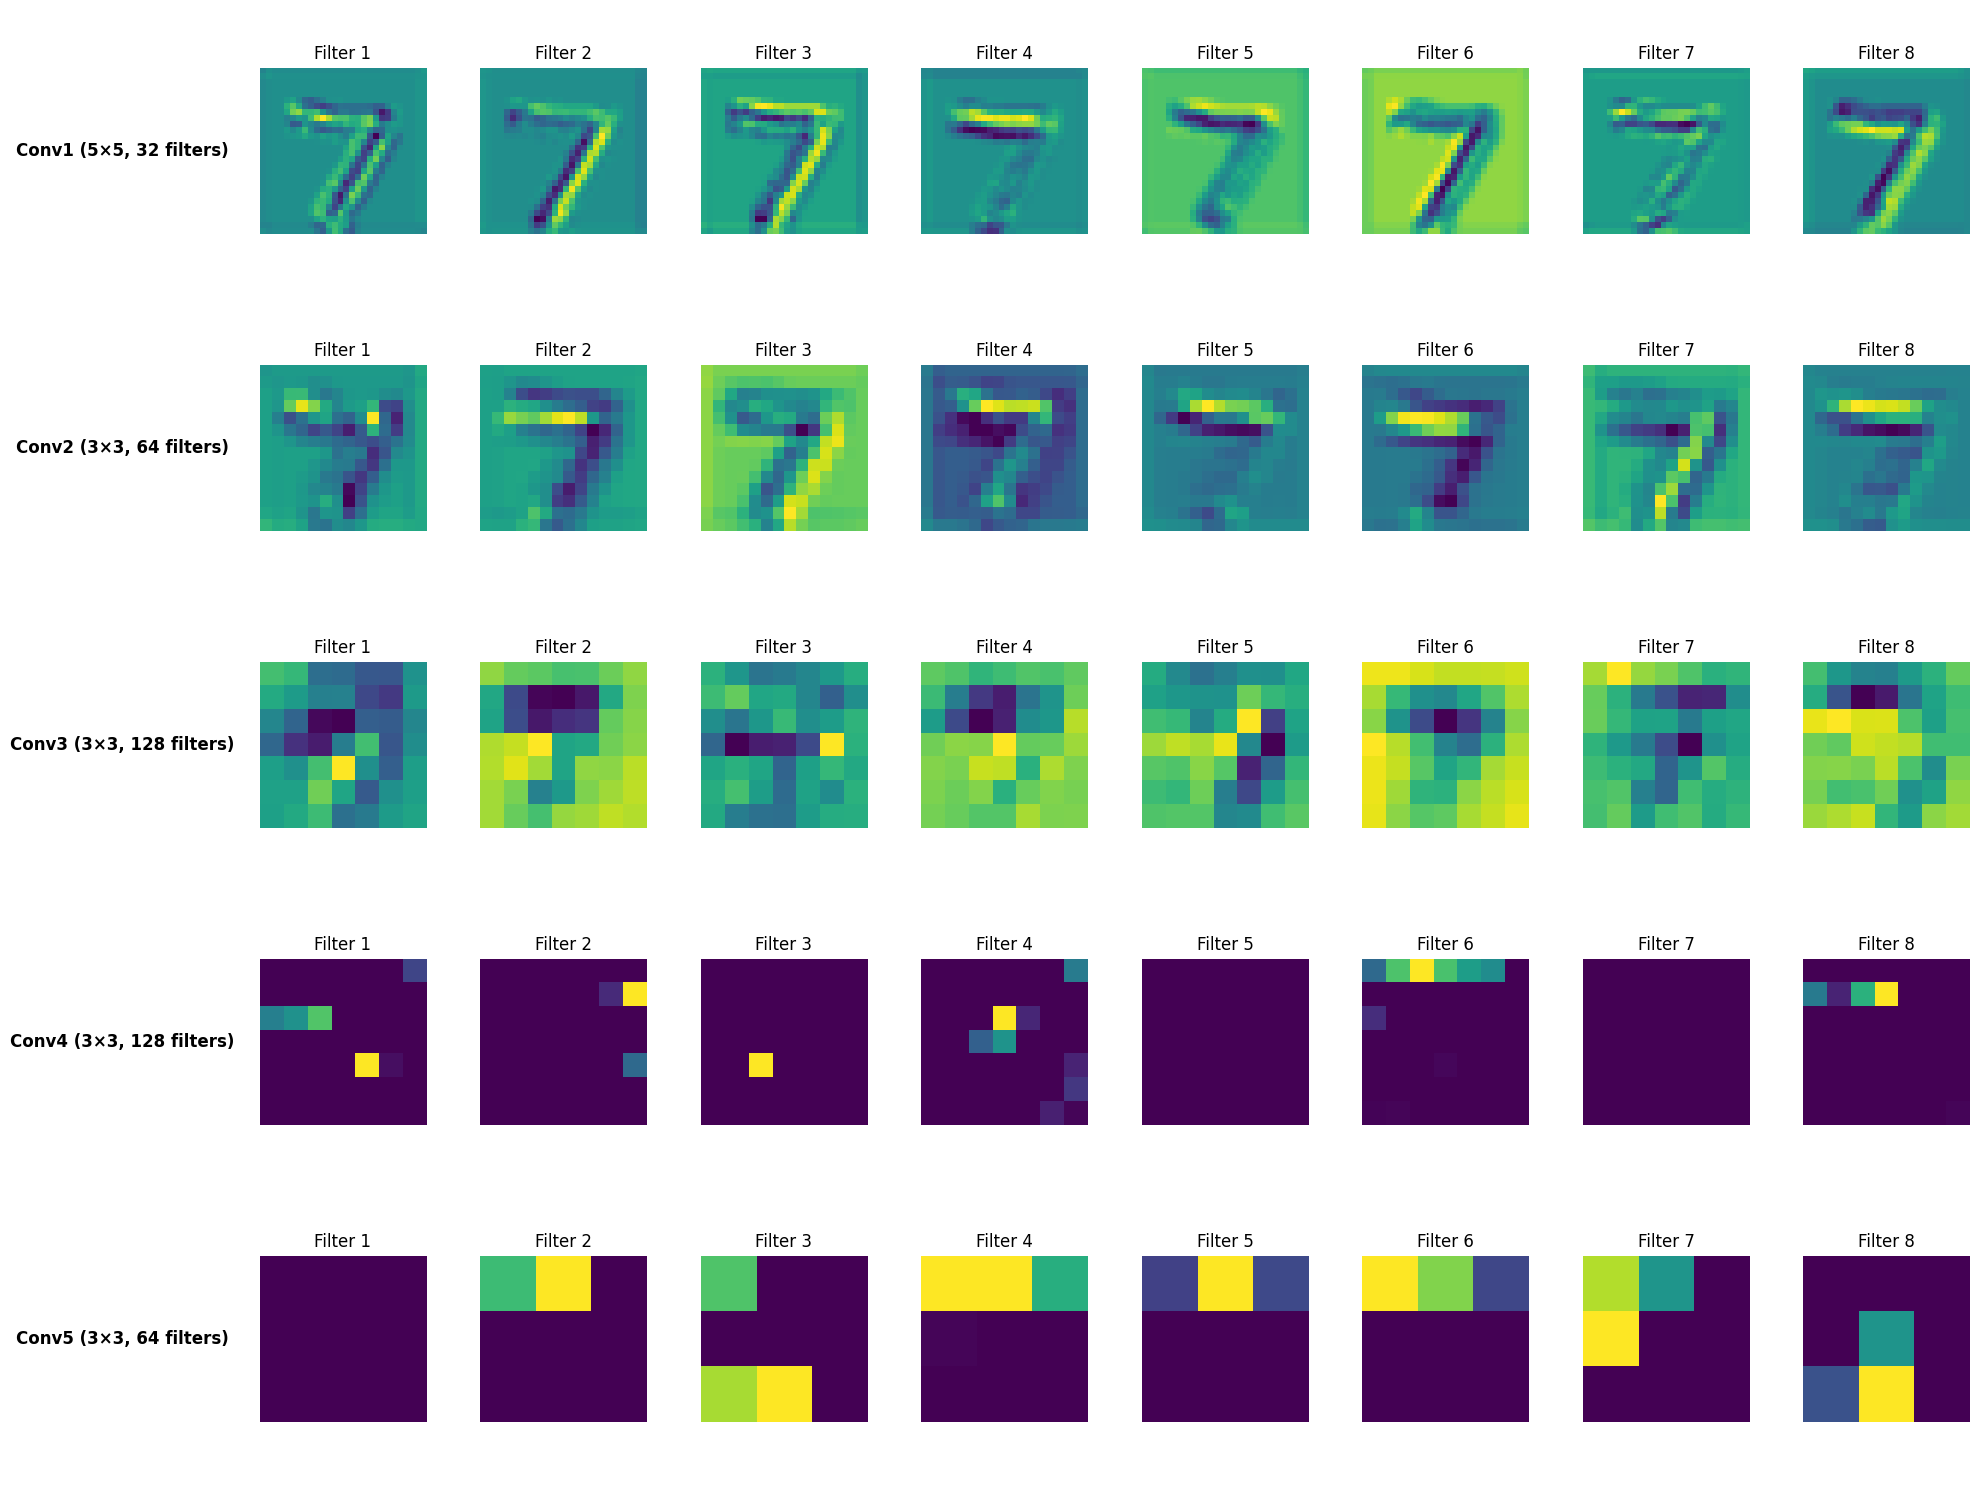

In [7]:
# AlexNet: Extract activations from all Conv layers
# Layer indices: 0 (Conv1), 3 (Conv2), 6 (Conv3), 9 (Conv4), 12 (Conv5)
print('AlexNet Activation Maps:')
alexnet_activations = get_activation_maps(alexnet, test_image_batch, [0, 3, 6, 9, 12])
alexnet_layer_names = [
    'Conv1 (5×5, 32 filters)',
    'Conv2 (3×3, 64 filters)',
    'Conv3 (3×3, 128 filters)',
    'Conv4 (3×3, 128 filters)',
    'Conv5 (3×3, 64 filters)'
]
visualize_activation_maps(alexnet_activations, alexnet_layer_names, num_filters=8)

## Task 5: Analyze Multiple Images

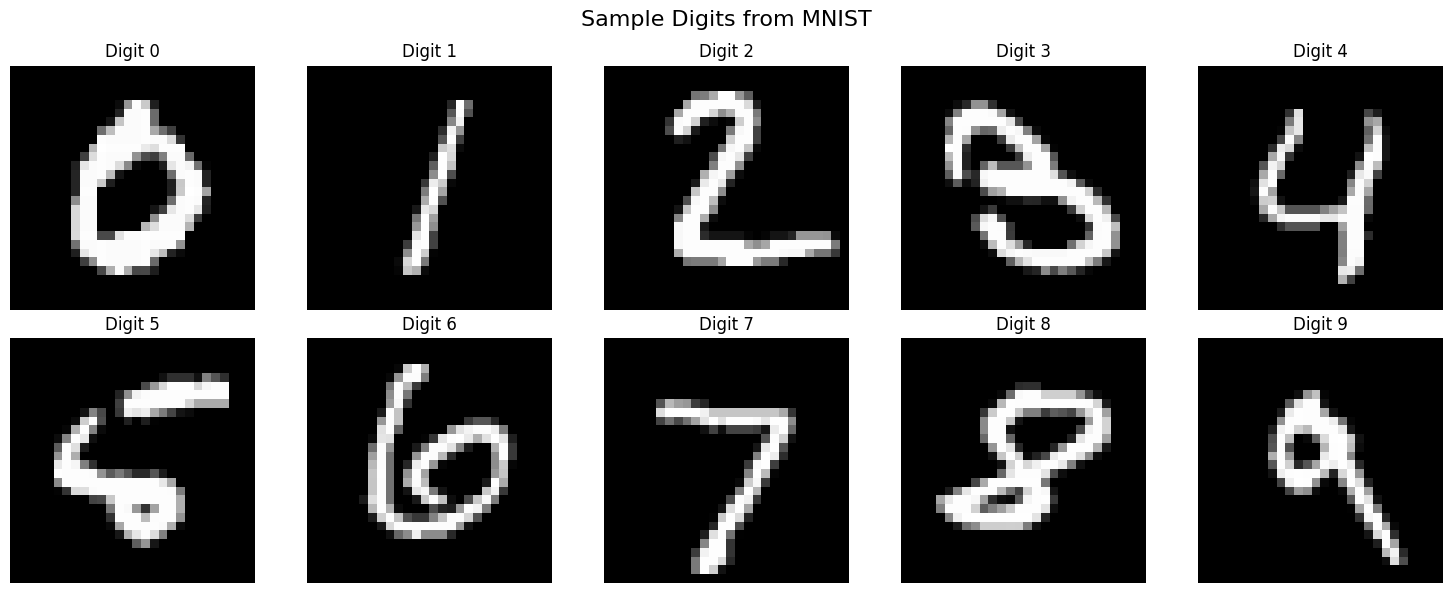


=== Analyzing Digit 0 ===


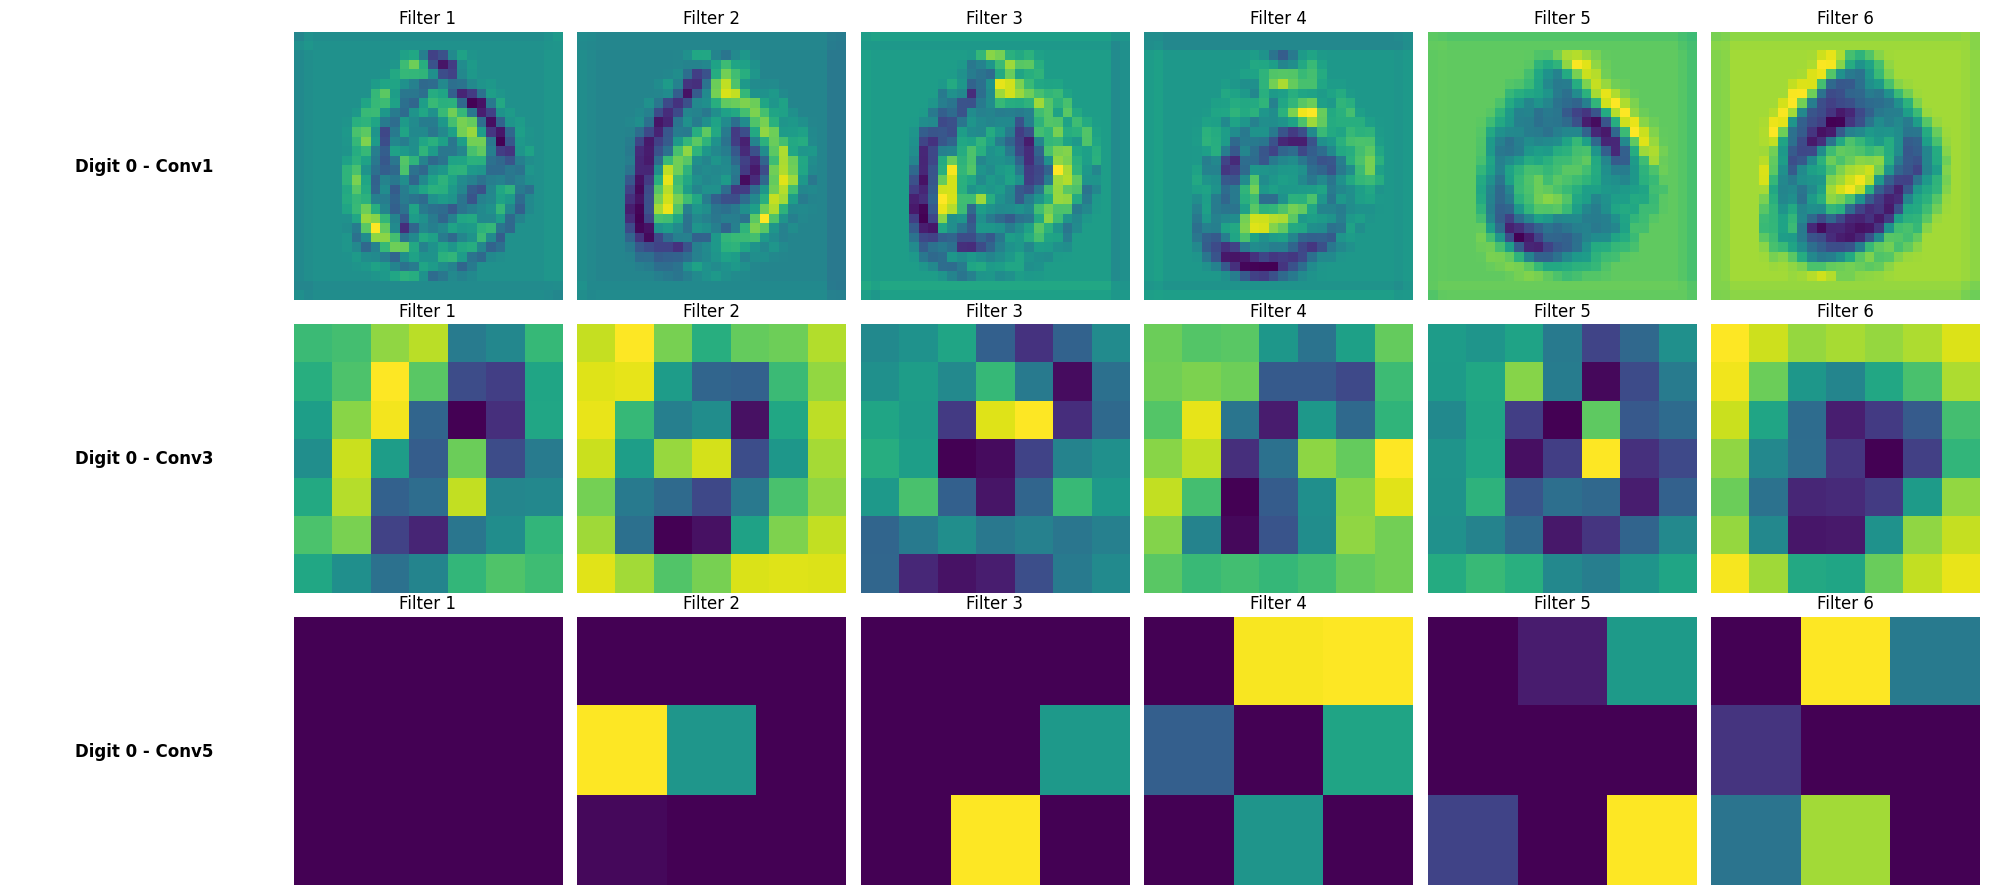


=== Analyzing Digit 1 ===


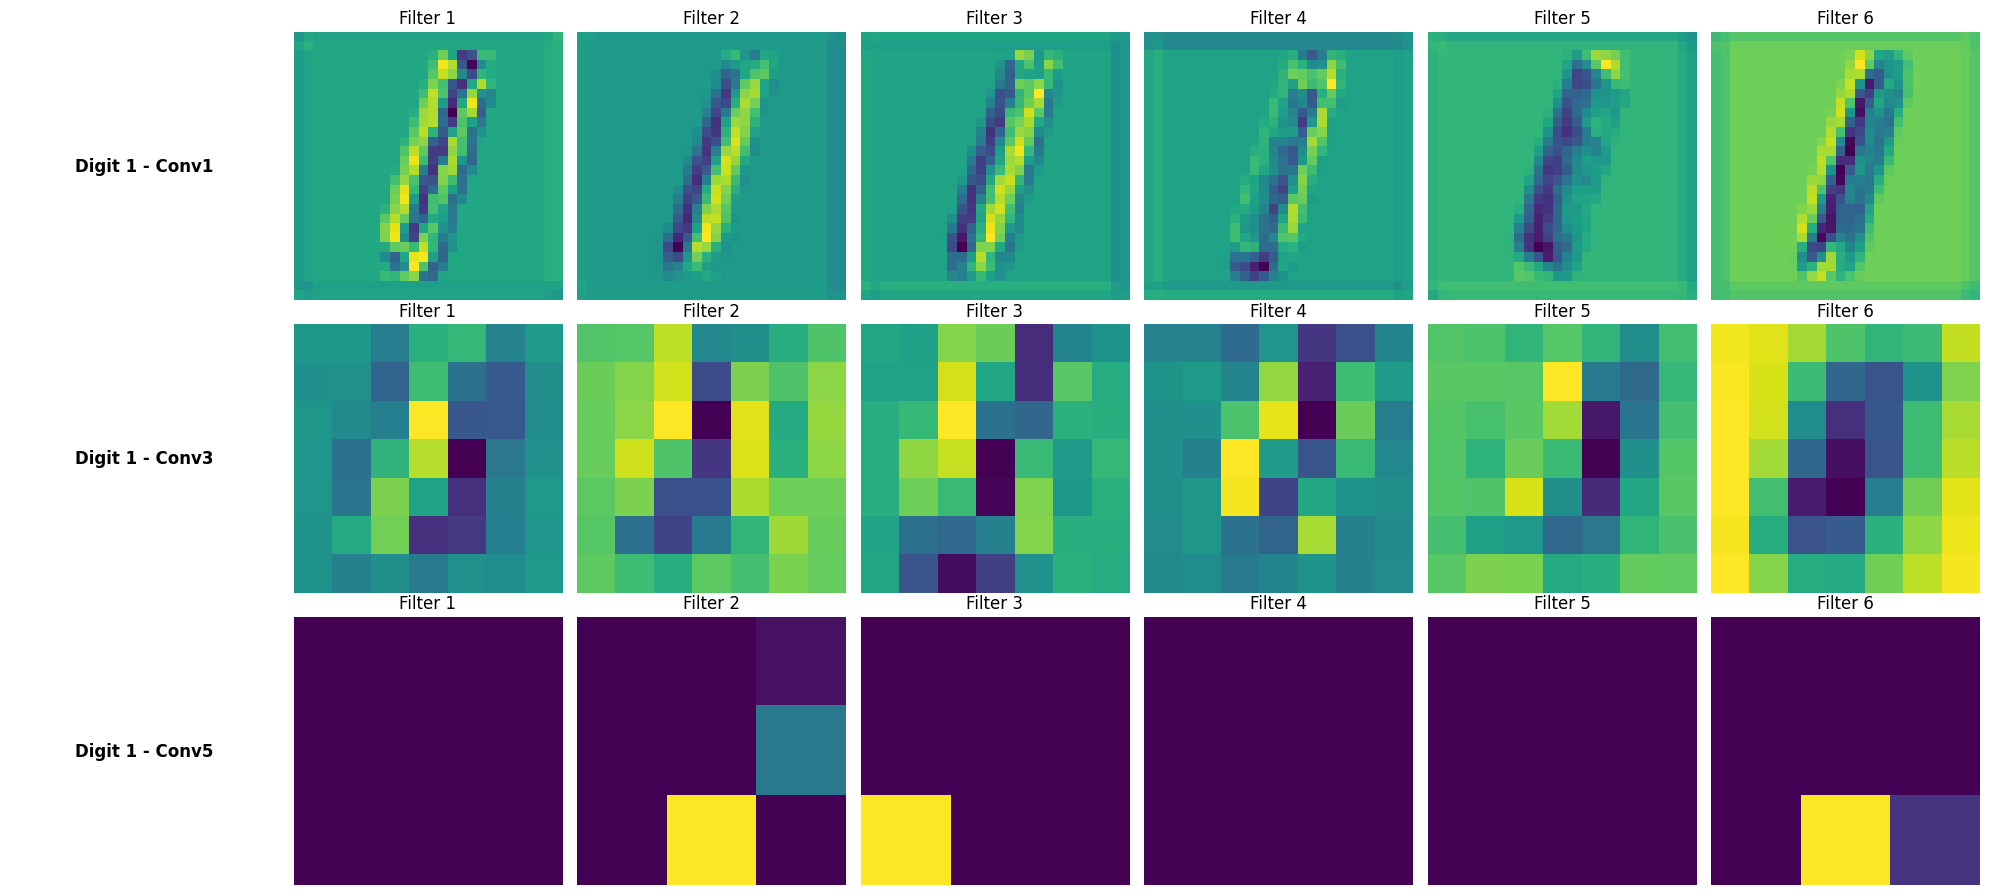


=== Analyzing Digit 3 ===


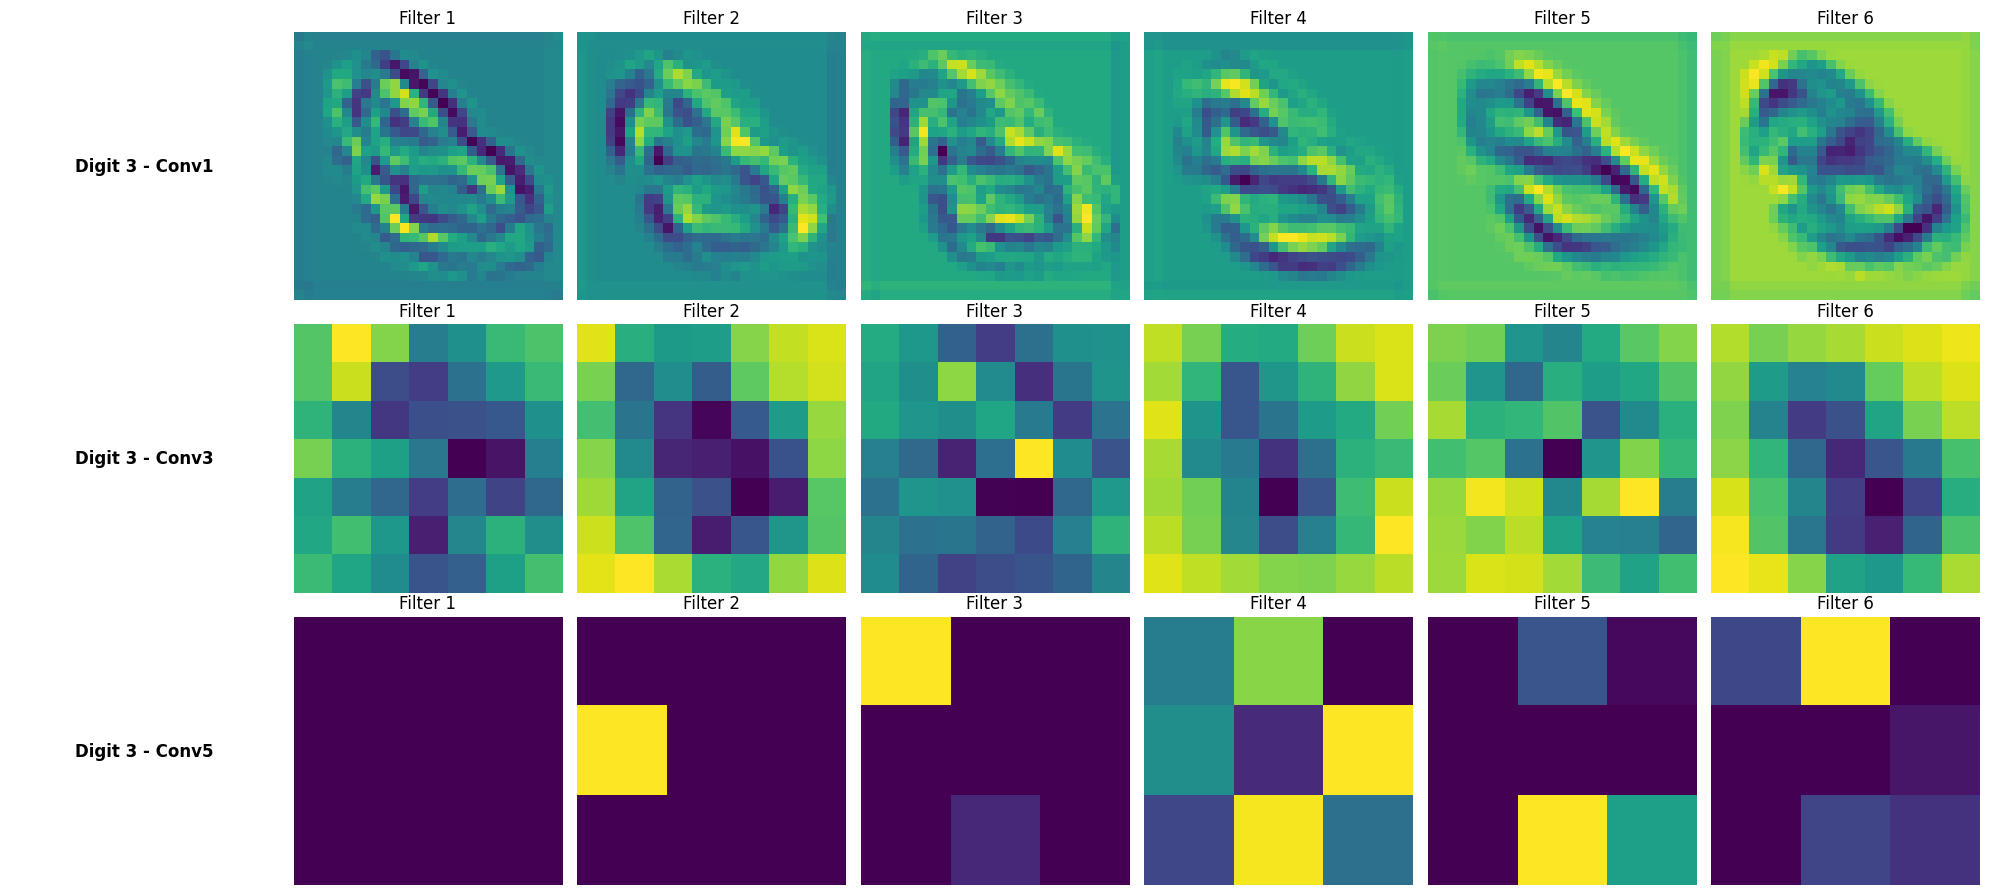


=== Analyzing Digit 7 ===


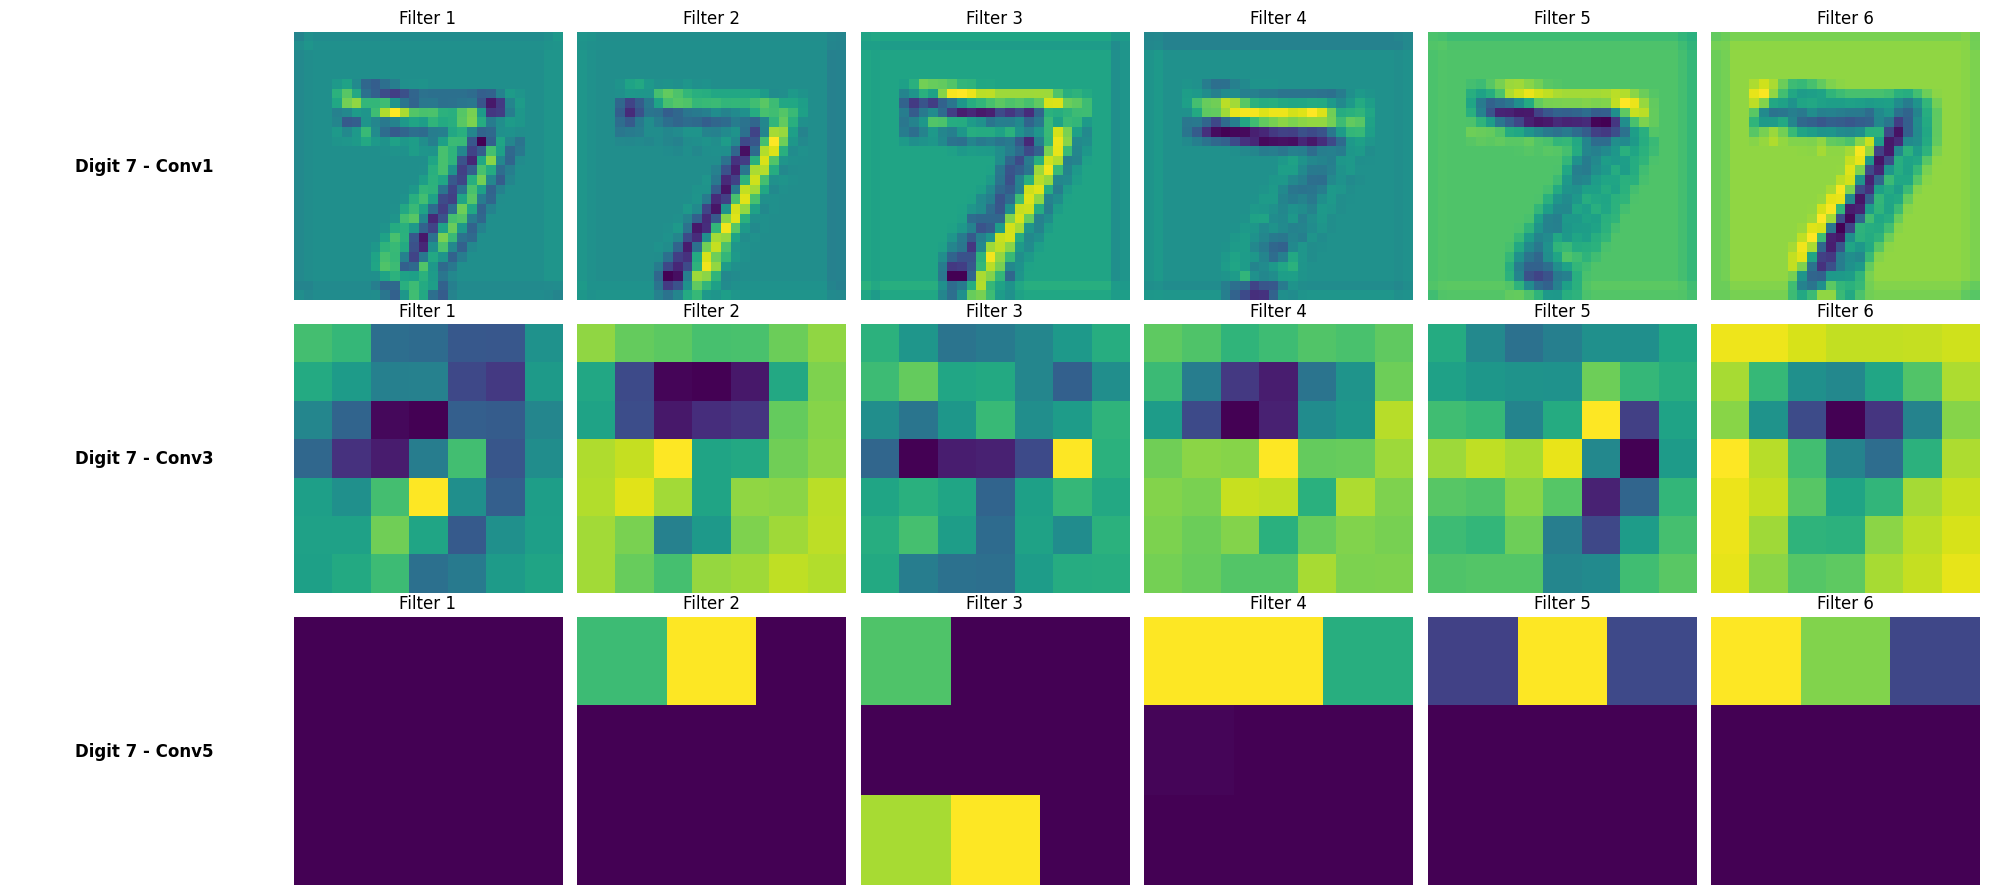


=== Analyzing Digit 8 ===


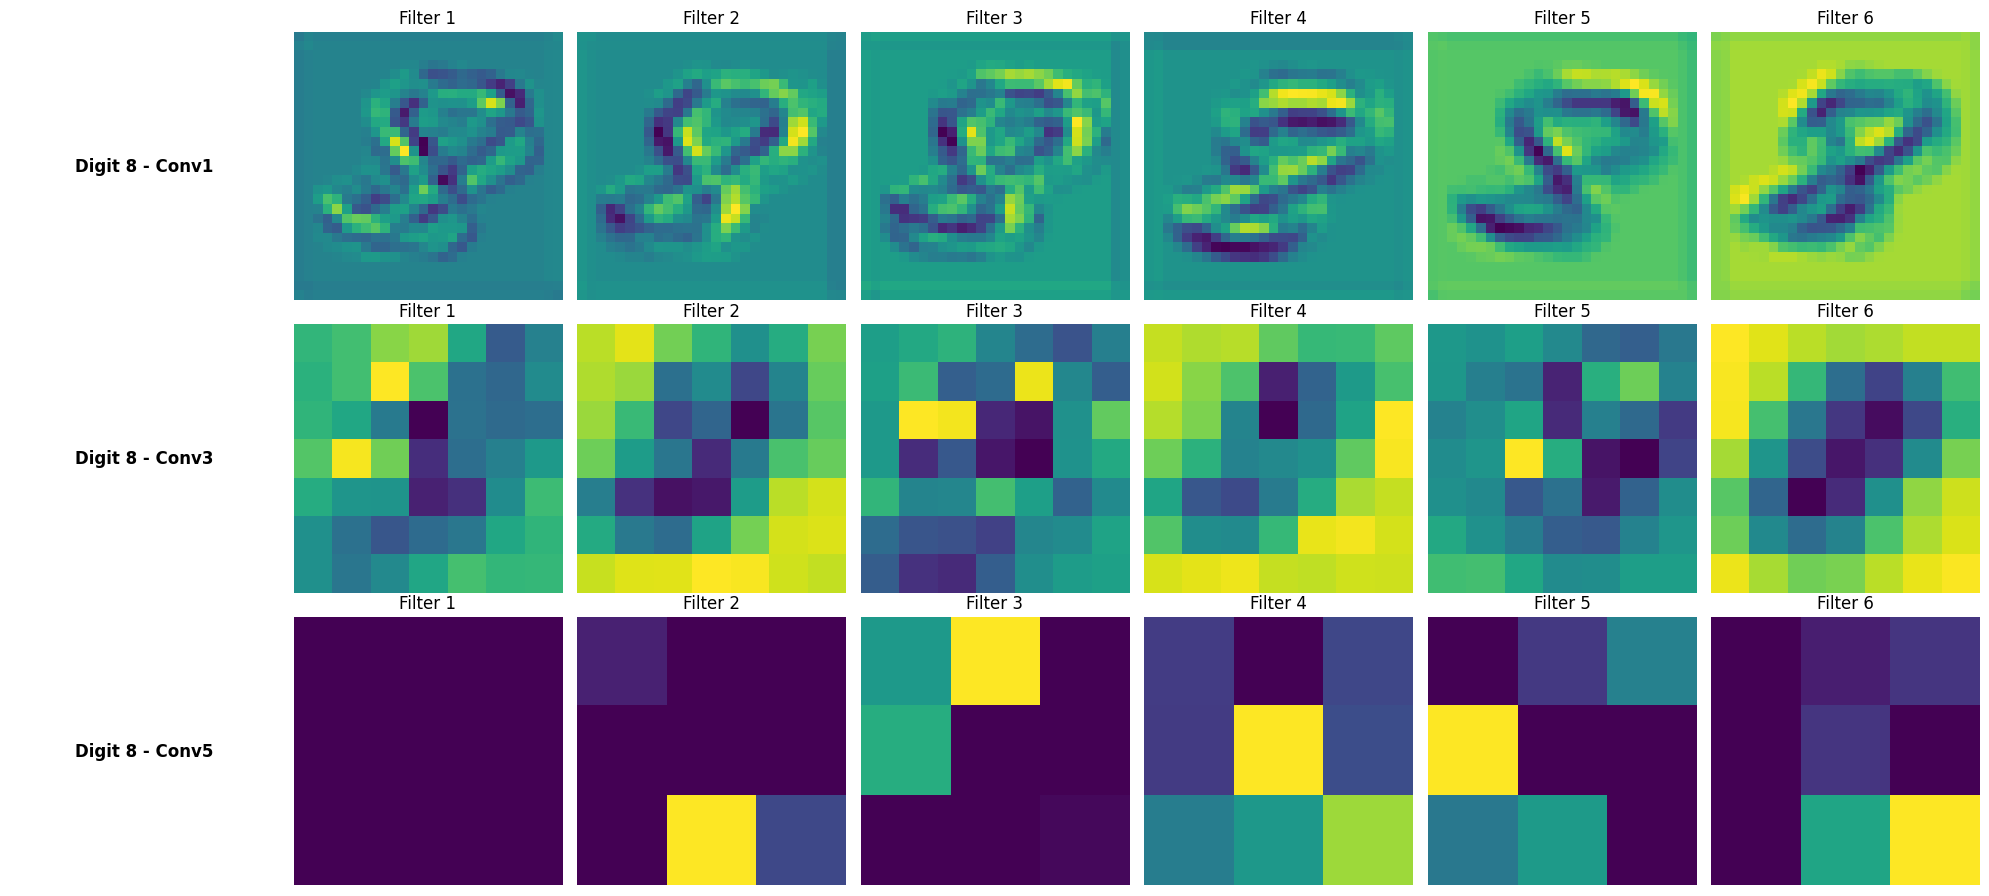

In [8]:
# Analyze different digits
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    # Find an image of digit i
    for img, label in test_dataset:
        if label == i:
            test_img = img
            break
    
    row = i // 5
    col = i % 5
    
    axes[row, col].imshow(test_img.squeeze().numpy(), cmap='gray')
    axes[row, col].set_title(f'Digit {i}')
    axes[row, col].axis('off')

plt.suptitle('Sample Digits from MNIST', fontsize=16)
plt.tight_layout()
plt.show()

# Analyze activation patterns for different digits
sample_digits = [0, 1, 3, 7, 8]

for digit in sample_digits:
    # Find image of this digit
    for img, label in test_dataset:
        if label == digit:
            test_img = img.unsqueeze(0).to(device)
            break
    
    print(f'\n=== Analyzing Digit {digit} ===')
    activations = get_activation_maps(alexnet, test_img, [0, 6, 12])
    visualize_activation_maps(activations, 
                             [f'Digit {digit} - Conv1', f'Digit {digit} - Conv3', f'Digit {digit} - Conv5'], 
                             num_filters=6)

## Task 6: Advanced Visualization - Feature Map Statistics

AlexNet Filter Statistics:


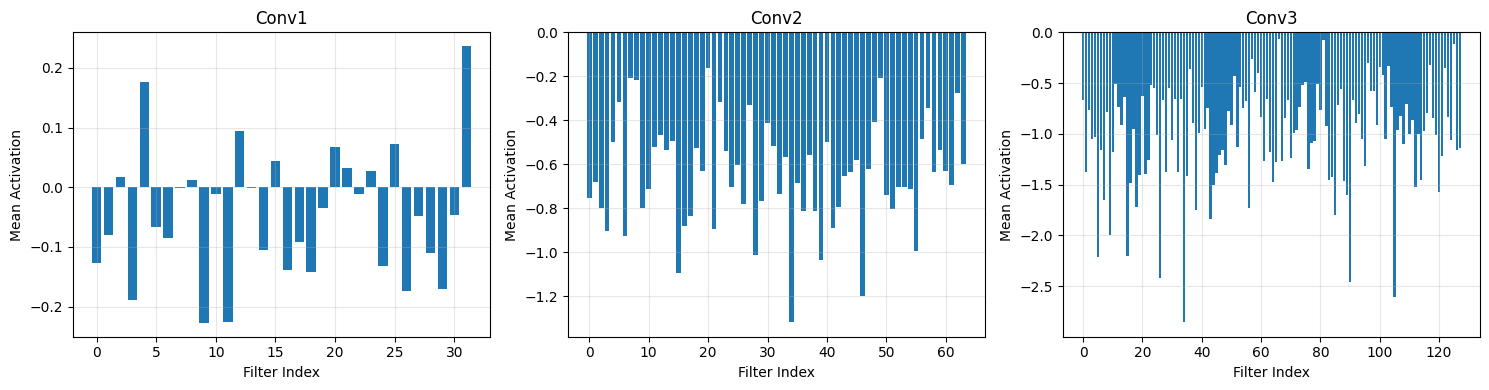

In [9]:
def plot_filter_statistics(activations, layer_names):
    """
    Plot statistics of activation maps (mean activation per filter).
    """
    fig, axes = plt.subplots(1, len(activations), figsize=(15, 4))
    
    for idx, (activation, layer_name) in enumerate(zip(activations, layer_names)):
        activation = activation.squeeze(0)  # (num_filters, H, W)
        mean_activations = activation.mean(dim=(1, 2)).numpy()
        
        axes[idx].bar(range(len(mean_activations)), mean_activations)
        axes[idx].set_title(layer_name)
        axes[idx].set_xlabel('Filter Index')
        axes[idx].set_ylabel('Mean Activation')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot statistics for AlexNet
print('AlexNet Filter Statistics:')
plot_filter_statistics(alexnet_activations[:3], 
                       ['Conv1', 'Conv2', 'Conv3'])